# CBCT to OPG
### This notebook is a representation of steps described in this [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5594999/) for 2d visualization of a cbct scan 

we start by installing libraries and importing them

In [1]:
# !pip install itkwidgets
# !pip install opencv-python

In [2]:
import ipyvolume as ipv
import pydicom
import numpy as np
import os
from itkwidgets import view

Use pydicom library to read every slice of image stored in a directory.
Ensure that all slices do have slicelocation attribute and are of the same size.

In [3]:
files = []
path = '/home/pariya/S0000001119/'
for s in os.listdir(path):
#     print("loading {}".format(s))
    files.append(pydicom.dcmread(path + s))
print("file count: {}".format(len(files)))

file count: 420


In [4]:
# skip files with no SliceLocation
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped {} slices".format(skipcount))

skipped 0 slices


In [5]:
sh = slices[0].pixel_array.shape
removed=[]
#ensure all slices are the same size
for s in slices:
    if sh!=s.pixel_array.shape:
        removed.append(s)

#remove slices with different shape
for r in removed:
    slices.remove(r)
    
# sort them is correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)


Stack up all the 2D arrays of slices to costruct a 3D array and visualize it using itkwidget.
take a good look at the image.

In [6]:
# create 3D array
img_shape = list(sh)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)
m=0

# fill 3D array with every 2D slice
for i, s in enumerate(slices):
    if s.pixel_array.shape != slices[0].pixel_array.shape:
        continue
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# 3D visualization of data
# view(img3d)

## 1. Intensity normalization

In order to find the threshhold first we visualize the intesity histogram, then fit a gaussian distribute to the histogram finally we get mean and standard deviation of data intensity.

In [7]:
#intensity normalization
def intensity_normalization(img):
    minimum = np.min(img)
    maximum = np.max(img)
    img = (img-minimum)/(maximum-minimum)
    return img

In [8]:
img3d=intensity_normalization(img3d)

A = 34050472.677  mu = 0.009  sigma = 0.031 k = -60193.788 $


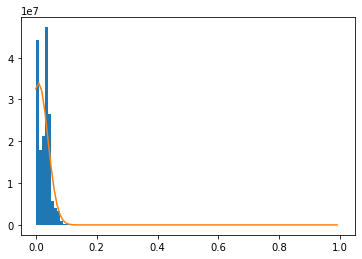

In [9]:
#intensity histogtram
from pylab import *
from scipy.optimize import leastsq
import matplotlib.pyplot as plt

x = np.linspace(0,1,101)
oneD_array=np.array(img3d.flatten())
n,bins,patches = plt.hist(oneD_array,x)

fitfunc  = lambda p, x: p[0]*exp(-0.5*((x-p[1])/p[2])**2)+p[3]
errfunc  = lambda p, x, y: (y - fitfunc(p, x))


init  = [1.0, 0.5, 0.5, 0.5]
out   = leastsq( errfunc, init, args=(x[:-1], n))
c = out[0]
# print (c[0],c[1],abs(c[2]),c[3])
plot(x[:-1], fitfunc(c,x[:-1] ))
print(r'A = %.3f  mu = %.3f  sigma = %.3f k = %.3f $' %(c[0],c[1],abs(c[2]),c[3]));

mu=c[1]
sigma=abs(c[2])

## 2.Thresholding
based on the paper we are going to use a linear combination of mean and standard deviation to determine threshold value.

In the paper it is proposed to find the slice that best represents patients dental arch to find template polynomial, but in this data i projected every slice on a 2d plane and summed up every slice to make a better representation of patients dental arc (due to missing tooth and imaging error), which led to choosing a larger value for w which is standard deviation's coeficient so before projecting all the slices filtering is done better.

In [10]:
#Thresholding
T = mu +3.8*sigma

Text(0.5, 1.0, 'slice 300')

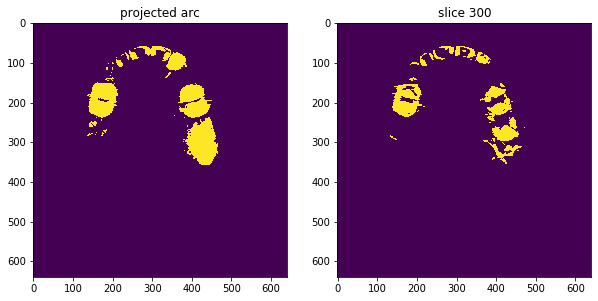

In [11]:
from copy import deepcopy
img=deepcopy(img3d)
img[img3d>T]=1
img[img3d<T]=0
#add slices 200 and the rest by second axis
img_proj=np.sum(img[:,:,200:335],axis=2)
img_proj[img_proj>0]=1

#comparison
TP=mu+3*sigma
img_p=deepcopy(img3d)
img_p[img3d>TP]=1
img_p[img3d<TP]=0

fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(img_proj)
axs[0].set_title("projected arc")
axs[1].imshow(img_p[:,:,300])
axs[1].set_title("slice 300")


In [12]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

## 3. Morphological operations (hole filling, closing, thinning)

In [13]:
from skimage import morphology

In [14]:
def marker_image(original):
    #produce marker image
    selem = morphology.square(2)
    eroded = morphology.erosion(original, selem)
    plot_comparison(original, eroded, 'erosion')
    dilated = morphology.dilation(original, selem)
    plot_comparison(original, dilated, 'dilation')
    marker=dilated-eroded
    plot_comparison(original,marker , 'marker')
    return marker

def hole_filling(original):
    #iterative hole-filling
    ic=np.logical_not(original)
    intersect=deepcopy(original)
    for i in range(300):
        selem = morphology.square(4)
        dilated = morphology.dilation(intersect, selem)
        intersect=np.logical_and(dilated,ic)
    hole_filled=np.logical_not(intersect)
    plot_comparison(original,hole_filled,"hole filled")
    return hole_filled

def closing(original):
    # morphological closing
    selem = morphology.disk(35)
    closed=morphology.closing(original,selem)
    plot_comparison(original,closed,'closing')
    return closed

def thinning(original):
    #morphological thinning
    skeleton=morphology.thin(original==1)
    plot_comparison(original,skeleton,"thinning")
    return skeleton

In [15]:
def plot_fitted_curve():
    skeleton=compute_thin()
    xn,yn=np.nonzero(np.rot90(skeleton))
    h ,w=skeleton.shape
    xn=w-xn
    coefs = np.poly1d(np.polyfit(xn, yn, 2))
    coefs[0]-=20
    xx = np.arange(0, w).astype(np.int)
    yy = np.polyval(coefs, xx)

    xx = xx[(0 <= yy) & (yy < h)]
    yy = yy[(0 <= yy) & (yy < h)].astype(np.int) 

    
    fig,axs=plt.subplots(1,3,figsize=(12,4))
    plt.ylim(0,640)
    plt.xlim(0,640)
    axs[0].plot(xn,yn,'.')
    axs[0].set_ylim(0,640)
    axs[0].set_xlim(0,640)
    axs[1].set_ylim(0,640)
    axs[1].set_xlim(0,640)
    axs[2].set_ylim(0,640)
    axs[2].set_xlim(0,640)
    axs[0].set_title("projected")
    axs[1].set_title('poly 6')
    axs[1].plot(xn,yn,'.',xx,yy,'.')
    axs[2].imshow(img_proj,origin="lower")
    axs[2].plot(xx,yy,'.')
    axs[2].set_title('with image')

    plt.show()
    return (xx,yy,coefs)

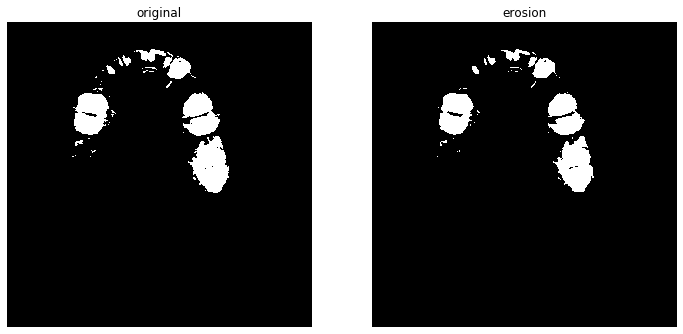

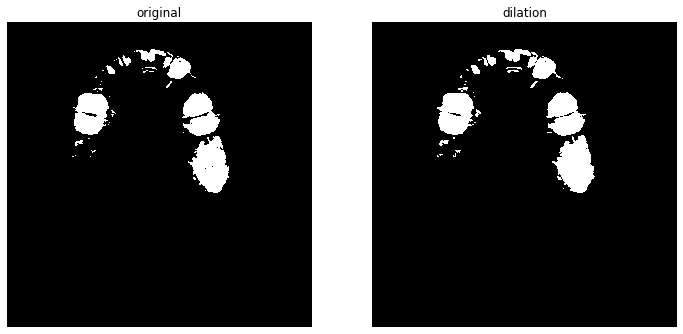

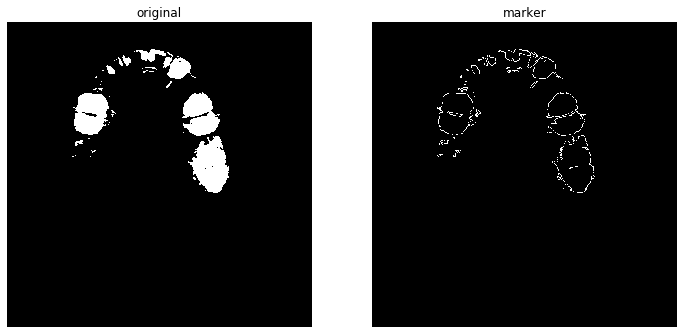

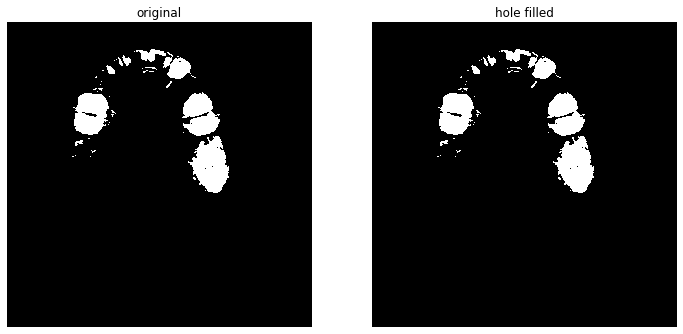

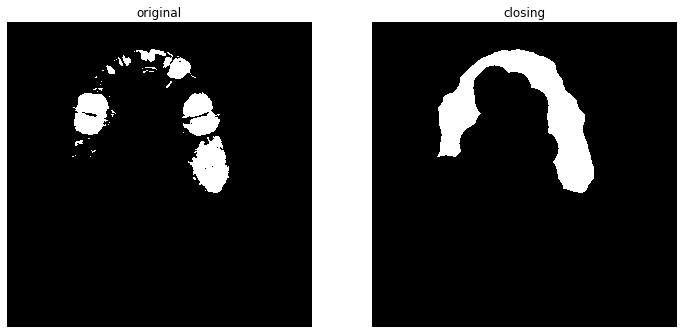

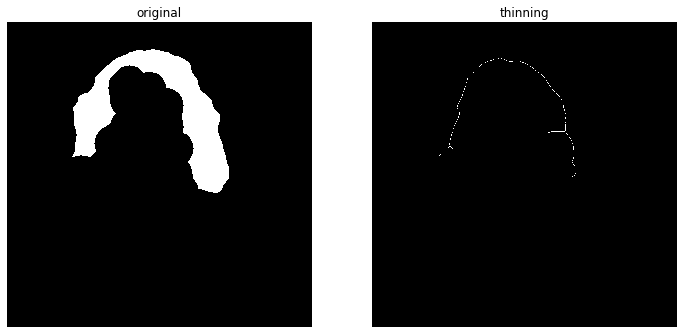

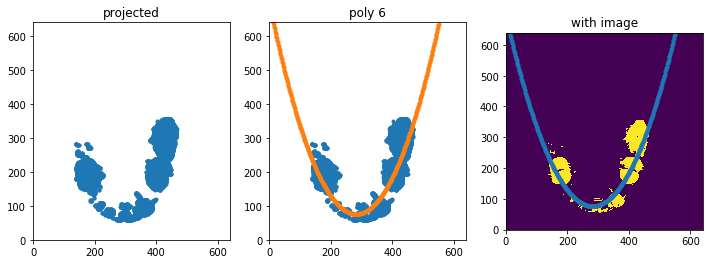

In [16]:
x,y,coefs=plot_fitted_curve()

419


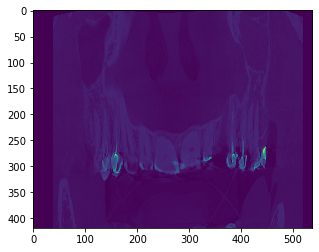

In [17]:
# 296 poly 6
opg=[]

w,h,d=img3d.shape
print(d)
for i in range(d):
    im=[]
    for j in range(len(x)):
        im.append(img3d[:,:,i][y[j]][x[j]])
    opg.append(im)
plt.imshow(opg)